# SNbone

This program emulates the inversion of A in A*x=S on a single node arch.  
This operation was identified as the bulk of the flop work and the largest memory issue for deterministic neutronics
  

This mini-app has three solution modes:
- The AVE-1 scheme refers to the standard matrix-free matrix-vector applications where gaussian integration is used
- The AVE-2 scheme refers to a slightly different approach from AVE-1 where intermediate vectors are used.
- The AVE-3 scheme refers to a conventional assembled matrix in compressed sparse row storage.

To date, AVE-3 consistently outperforms AVE-1 and AVE-2 such that fully assembling the matrix and performing the solve is more efficient than doing the gaussian integration solve. 


---
## Parameters 
```
Compiler = icpc (ICC) 18.0.1 20171018
Build_Flags = -g -O3 -march=native -DUSEMETIS -qopenmp -DWITHOMP
Run_Parameters = 0 100 30 32 [#threads]
```

---
## Setup

README.txt:
```
The code is broken into three steps.
1) You create an unstructured mesh but it has a regular stencil such that the bandwidth is not as severe as a conventional FE mesh
   You can theoretically provide a linear tetrahedral finite element mesh from a conventional mesh generator as an alternative. Ask for details.
2) You process this mesh with respect to the maximum number of threads you want to investigate
   The mesh will be re-ordered with respect to element and vertex such that it can be applied in n*thread independent steps.
3) You run the mini-app (fortran or c version) to look at the overall performance on a particular architecture
```

### Setup Parameters
```
makemesh.x 10 10 10 0
processmesh.x 1 72
```

---
## Scaling


In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

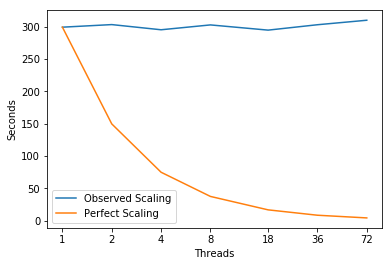

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads,[299.0, 303.0, 295.0, 302.5, 294.4444444444444, 302.77777777777777, 309.72222222222223],
        label='Observed Scaling')
ax.plot(Threads, [299.0, 149.5, 74.75, 37.375, 16.61111111111111, 8.305555555555555, 4.152777777777778],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Intel Software Development Emulator 
| SDE Metrics | SNbone |
|:-----------|:---:|
| **Arithmetic Intensity** | 0.13 |
| **Bytes per Load Inst** | 7.98 |
| **Bytes per Store Inst** | 6.95 |

---
## Roofline  -  Intel(R) Xeon(R) CPU E5-2699 v3 @ 2.30GHz
### 72 Threads - 36 - Cores 2300.0 Mhz
|     GB/sec     |  L1 B/W |  L2 B/W |  L3 B/W | DRAM B/W |
|:---------------|:-------:|:-------:|:-------:|:--------:|
|**1 Thread**  | 143.1 |  44.87 | 33.12 |   16.04  |
|**36 Threads**  | 2509.07 |  807.72 | 558.03 |   58.38  |
|**72 Threads**  | 2391.14 |  792.13 | 581.89 |   42.97  |

---
### Experiment Aggregate Metrics

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (100.0%)|2.10|1.13|1.20|0.27%|30.60%|24.30%|1.26%|1.33%|0.30%|
|36 (100.0%)|1.65|0.68|0.73|0.33%|25.48%|14.43%|1.71%|1.65%|0.65%|
|72 (100.0%)|1.66|0.45|0.49|0.54%|20.73%|10.71%|3.89%|2.62%|0.58%|

---
### ApplyA_AVE1_Tet_SUPG
```c
 35 // Main subroutine header
 36 void ApplyA_AVE1_Tet_SUPG(int *NE, int *NA, int *NV, int *C,
 37                            int *AS_NumColors,int *AS_NumThreads,int *TasksPerThread,int *MyThreadID,int *ThreadWiseWork,
 38                               double *CF, double *CU, double *CP, double *FES, double *FED, double *FEW, double *OM, double *OO,
 39                               double *LHS, double *RHS) {
 40 // Problem size arguments and mesh data
 41 //INTEGER,     INTENT(IN) :: NE           // Number of Es
 42 //INTEGER,     INTENT(IN) :: NA                    // Number of angles
 43 //INTEGER,     INTENT(IN) :: NV           // Number of vertices in the mesh
 44 //INTEGER,     INTENT(IN) :: C(4*NE)      // The connectivity matrix
 45 // Thread size arguments and work seperation
 46 //INTEGER,     INTENT(IN) :: AS_NumColors,AS_NumThreads,TasksPerThread,MyThreadID
 47 //INTEGER,     INTENT(IN) :: ThreadWiseWork(2,AS_NumColors,AS_NumThreads) ! The element start/stop for each thread in each color
 48 // Cross section vectors
 49 //REAL*8,    INTENT(IN) :: CF(NE)
 50 //REAL*8,    INTENT(IN) :: CU(NE)
 51 //REAL*8,    INTENT(IN) :: CP(NE)
 52 // FE shape functions
 53 //REAL*8, INTENT(IN) :: FES(4*4)               // Vertices,GP     // Shape
 54 //REAL*8, INTENT(IN) :: FED(4*3*4*NE) // Vertices,Dim,GP // Derivatives in real space
 55 //REAL*8, INTENT(IN) :: FEW(4*NE)     // GP              // Weight * |Jac|
 56 // Angular cubature
 57 //REAL*8, INTENT(IN) :: OM(NA*3)                   // Angular cubature evaluation
 58 //REAL*8, INTENT(IN) :: OO(NA*6)                   // Basically it is OM(A,*) * OM(A,*)
 59 // Vectors
 60 //REAL*8, INTENT(INOUT) :: LHS(NA*NV) // LHS (to be modified)
 61 //REAL*8,    INTENT(IN) :: RHS(NA*NV) // RHS (to be multiplied)
 62 
 63 // Local
 64 int E,A,V,VV,GP,iNA;
 65 int iCV_E,iCVV_E,iGP,iEGP,iEGP1,iEGP2,iEGP3;
 66 int iColor,iStart,iEnd;
 67 int AS_Thread,iTask,ifun;
 68 
 69 iNA = *NA;
 70 //printf("NA=%d NE=%d NV=%d \n",*NA,*NE,*NV);
 71 
 72 for (iColor = 1; iColor < *AS_NumColors+1; iColor++) {
 73 #ifdef WITHOMP
 74  for (iTask = 1; iTask < *TasksPerThread+1; iTask++) {
 75    AS_Thread = *TasksPerThread * (*MyThreadID-1) + iTask;
 76    ifun = *AS_NumColors * (AS_Thread-1)*2 + 2*(iColor-1);
 77    iStart   = ThreadWiseWork[ifun+1-1];
 78    iEnd     = ThreadWiseWork[ifun+2-1];
 79 //   iStart   = ThreadWiseWork[(iColor-1)*2+1-1];
 80 //   iEnd     = ThreadWiseWork[(iColor-1)*2+2-1];
 81 #else
 82    iStart = 1;
 83    iEnd   = *NE;
 84 #endif
 85    for (E = iStart; E < iEnd+1; E++) {
 86       for (V = 1; V < 5; V++) {
 87          //printf("E=%d V=%d ii=%d \n",E,V,(E-1)*4+V-1);
 88          iCV_E = (C[(E-1)*4+V-1]-1)*iNA-1;
 89          for (GP = 1; GP < 5; GP++) {
 90             iGP  = (GP-1)*4-1;
 91             iEGP  = (E-1)*4+GP-1;
 92             iEGP1 = (E-1)*4*3*4 + (GP-1)*3*4 + (1-1)*4-1;
 93             iEGP2 = (E-1)*4*3*4 + (GP-1)*3*4 + (2-1)*4-1;
 94             iEGP3 = (E-1)*4*3*4 + (GP-1)*3*4 + (3-1)*4-1;
 95             for (VV = 1; VV < 5; VV++) {
 96                iCVV_E = (C[(E-1)*4+VV-1]-1)*iNA-1;
 ```
 
  |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (51.4%)|2.09|1.48|1.52|0.05%|22.54%|38.01%|0.27%|0.18%|0.01%|
|36 (7.3%)|2.07|1.68|1.72|0.05%|22.18%|33.89%|0.57%|0.42%|0.10%|
|72 (7.7%)|2.05|1.24|1.28|0.07%|21.31%|37.09%|1.26%|0.86%|0.37%|
 
 ```c
 97                for (A = 1; A < iNA+1; A++) {
                      /*...Commented Out Code...}*/
104                // There are 4+15+45*GP*V*V=64*4*4*4=4096 mults per element-angle and 13*GP*V*V=832 adds so 4928 flops
105                   LHS[iCV_E+A] = LHS[iCV_E+A]
106                                 + FEW[iEGP]*CF[E-1]              *FES[iGP+V]  *FES[iGP+VV]  *RHS[iCVV_E+A]    // F
107                                 + FEW[iEGP]*CU[E-1]*OM[A-1]      *FED[iEGP1+V]*FES[iGP+VV]  *RHS[iCVV_E+A]    // U^T[1]
108                                 + FEW[iEGP]*CU[E-1]*OM[iNA+A-1]  *FED[iEGP2+V]*FES[iGP+VV]  *RHS[iCVV_E+A]    // U^T[2]    
109                                 + FEW[iEGP]*CU[E-1]*OM[2*iNA+A-1]*FED[iEGP3+V]*FES[iGP+VV]  *RHS[iCVV_E+A]    // U^T[3]
110                                 + FEW[iEGP]*CP[E-1]*OO[A-1]      *FED[iEGP1+V]*FED[iEGP1+VV]*RHS[iCVV_E+A]    // P[1,1]
111                                 + FEW[iEGP]*CP[E-1]*OO[iNA+A-1]  *FED[iEGP2+V]*FED[iEGP2+VV]*RHS[iCVV_E+A]    // P[2,2]
112                                 + FEW[iEGP]*CP[E-1]*OO[2*iNA+A-1]*FED[iEGP3+V]*FED[iEGP3+VV]*RHS[iCVV_E+A]    // P[3,3]
113                                 + FEW[iEGP]*CP[E-1]*OO[3*iNA+A-1]*FED[iEGP1+V]*FED[iEGP2+VV]*RHS[iCVV_E+A]    // P[1,2]
114                                 + FEW[iEGP]*CP[E-1]*OO[4*iNA+A-1]*FED[iEGP1+V]*FED[iEGP3+VV]*RHS[iCVV_E+A]    // P[1,3]
115                                 + FEW[iEGP]*CP[E-1]*OO[5*iNA+A-1]*FED[iEGP2+V]*FED[iEGP3+VV]*RHS[iCVV_E+A]    // P[2,3]
116                                 + FEW[iEGP]*CP[E-1]*OO[3*iNA+A-1]*FED[iEGP2+V]*FED[iEGP1+VV]*RHS[iCVV_E+A]    // P[2,1]
117                                 + FEW[iEGP]*CP[E-1]*OO[4*iNA+A-1]*FED[iEGP3+V]*FED[iEGP1+VV]*RHS[iCVV_E+A]    // P[3,1]
118                                 + FEW[iEGP]*CP[E-1]*OO[5*iNA+A-1]*FED[iEGP3+V]*FED[iEGP2+VV]*RHS[iCVV_E+A] ;  // P[3,2]
                      /*...Commented Out Code...*/
132                } // A
133             } // VV
134          } // GP
135       } // V
136    } // E
137 #ifdef WITHOMP
138  } // iTask
139 #pragma omp barrier
140 #else
141    break;
142 #endif
143 } // iColor
144 
145 } // END SUBROUTINE ApplyA_AVE1_Tet_SUPG
```


---
### ApplyA_AVE2_Tet_SUPG
```c
 35 // Main subroutine header
 36 void ApplyA_AVE2_Tet_SUPG(int *NE, int *NA, int *NV, int *C,
 37                            int *AS_NumColors,int *AS_NumThreads,int *TasksPerThread,int *MyThreadID,int *ThreadWiseWork,
 38                               double *CF, double *CU, double *CP, double *FES, double *FED, double *FEW, double *OM, double *OO,
 39                               double *LHS, double *RHS,double *SRHS,double *SLHS) {
 40 //IMPLICIT NONE 
 41 //#include "PROTEUS_Preprocess.h"
 42 //#define Local_TryLHStoo
 43 // Problem size arguments and mesh data
 44 //PROTEUS_Int,     INTENT(IN) :: NE            // Number of Es
 45 //PROTEUS_Int,     INTENT(IN) :: NA              // Number of angles
 46 //PROTEUS_Int,     INTENT(IN) :: NV                // Number of vertices in the mesh
 47 //PROTEUS_Int,     INTENT(IN) :: C(4,NE)       // The connectivity matrix
 48 //// Thread size arguments and work seperation
 49 //PROTEUS_Int,     INTENT(IN) :: AS_NumColors,AS_NumThreads,TasksPerThread,MyThreadID
 50 //PROTEUS_Int,     INTENT(IN) :: ThreadWiseWork(2,AS_NumColors,AS_NumThreads) // The element start/stop for each thread in each color
 51 //// Cross section vectors
 52 //PROTEUS_Real,    INTENT(IN) :: CF(NE)
 53 //PROTEUS_Real,    INTENT(IN) :: CU(NE)
 54 //PROTEUS_Real,    INTENT(IN) :: CP(NE)
 55 //// FE shape functions
 56 //PROTEUS_FE_Real, INTENT(IN) :: FES(4,4)               // Vertices,GP     // Shape
 57 //PROTEUS_FE_Real, INTENT(IN) :: FED(4,3,4,NE) // Vertices,Dim,GP // Derivatives in real space
 58 //PROTEUS_FE_Real, INTENT(IN) :: FEW(4,NE)     // GP              // Weight * |Jac|
 59 //// Angular cubature
 60 //PROTEUS_FE_Real, INTENT(IN) :: OM(NA,3)                   // Angular cubature evaluation
 61 //PROTEUS_FE_Real, INTENT(IN) :: OO(NA,6)                   // Basically it is OM(A,*) * OM(A,*)
 62 //// Vectors
 63 //PROTEUS_Real, INTENT(INOUT) :: LHS(NA,NV) // LHS (to be modified)
 64 //PROTEUS_Real,    INTENT(IN) :: RHS(NA,NV) // RHS (to be multiplied)
 65 //// Scratch vectors
 66 //PROTEUS_Real, INTENT(INOUT) :: SRHS(NA,4),SLHS(NA,4)
 67 
 68 // Local
 69 int E,A,V,VV,GP,iNA;
 70 int iCV_E,iCVV_E,iGP,iEGP,iEGP1,iEGP2,iEGP3;
 71 int iColor,iStart,iEnd;
 72 int AS_Thread,iTask,ifun;
 73 double LocalConst1,LocalConst2,LocalConst3,Products[11];
 74 
 75 iNA = *NA;
 76 
 77 //printf("NA=%d NE=%d NV=%d \n",*NA,*NE,*NV);
 78 
 79 for (iColor = 1; iColor < *AS_NumColors+1; iColor++) {
 80 #ifdef WITHOMP
 81  for (iTask = 1; iTask < *TasksPerThread+1; iTask++) {
 82    AS_Thread = *TasksPerThread * (*MyThreadID-1) + iTask;
 83    ifun = *AS_NumColors * (AS_Thread-1)*2 + 2*(iColor-1);
 84    iStart   = ThreadWiseWork[ifun+1-1];
 85    iEnd     = ThreadWiseWork[ifun+2-1];
 86 //   iStart   = ThreadWiseWork[(iColor-1)*2+1-1];
 87 //   iEnd     = ThreadWiseWork[(iColor-1)*2+2-1];
 88 #else
 89    iStart = 1;
 90    iEnd   = *NE;
 91 #endif
 92    for (E = iStart; E < iEnd+1; E++) {
 93       for (V = 1; V < 5; V++) {
 94          // Pull a copy of the vectors
 95          iCV_E = (C[(E-1)*4+V-1]-1)*iNA-1;
 96          for (A = 1; A < iNA+1; A++) {
 97             SRHS[(V-1)*iNA+A-1] = RHS[iCV_E + A];
 98 #ifdef Local_TryLHStoo
 99             SLHS[(V-1)*iNA+A-1] = LHS[iCV_E + A];
100 #endif
101          }
102       }
103       for (V = 1; V < 5; V++) {
104 #ifndef Local_TryLHStoo
105          iCV_E = (C[(E-1)*4+V-1]-1)*iNA-1; // II = C(V,E)
106 #endif
107          for (GP = 1; GP < 5; GP++) {
108             iGP  = (GP-1)*4-1;
109             iEGP  = (E-1)*4+GP-1;
110             iEGP1 = (E-1)*4*3*4 + (GP-1)*3*4 + (1-1)*4-1;
111             iEGP2 = (E-1)*4*3*4 + (GP-1)*3*4 + (2-1)*4-1;
112             iEGP3 = (E-1)*4*3*4 + (GP-1)*3*4 + (3-1)*4-1;
113 
114             LocalConst1 = FEW[iEGP]*CF[E-1];
115             LocalConst2 = FEW[iEGP]*CU[E-1];
116             LocalConst3 = FEW[iEGP]*CP[E-1];
117             for (VV = 1; VV < 5; VV++) {
118                iCVV_E = (VV-1)*iNA-1; //(C[(E-1)*4+VV-1]-1)*iNA-1;
119                Products[ 1] = LocalConst1*FES[iGP+V]  *FES[iGP+VV];
120                Products[ 2] = LocalConst2*FED[iEGP1+V]*FES[iGP+VV];
121                Products[ 3] = LocalConst2*FED[iEGP2+V]*FES[iGP+VV];
122                Products[ 4] = LocalConst2*FED[iEGP3+V]*FES[iGP+VV];
123                Products[ 5] = LocalConst3*FED[iEGP1+V]*FED[iEGP1+VV];
124                Products[ 6] = LocalConst3*FED[iEGP2+V]*FED[iEGP2+VV];
125                Products[ 7] = LocalConst3*FED[iEGP3+V]*FED[iEGP3+VV];
126                Products[ 8] = LocalConst3*(FED[iEGP1+V]*FED[iEGP2+VV]+FED[iEGP2+V]*FED[iEGP1+VV]);
127                Products[ 9] = LocalConst3*(FED[iEGP1+V]*FED[iEGP3+VV]+FED[iEGP3+V]*FED[iEGP1+VV]);
128                Products[10] = LocalConst3*(FED[iEGP2+V]*FED[iEGP3+VV]+FED[iEGP3+V]*FED[iEGP2+VV]);
```

 |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (22.1%)|1.95|1.09|1.21|0.07%|23.10%|31.02%|0.30%|0.29%|0.01%|
|36 (5.8)|1.96|1.27|1.41|0.07%|23.67%|9.52%|0.62%|0.64%|0.02%|
|72 (7.3%)|1.96|0.98|1.08|0.10%|23.76%|8.82%|1.54%|1.39%|0.06%|

```c
129                for (A = 1; A < iNA+1; A++) {
130 #ifdef Local_TryLHStoo
131                   SLHS[iCVV_E+A] = SLHS[iCVV_E+A]
132                                         + Products[ 1]              *SRHS[iCVV_E+A]    // F
133                                         + Products[ 2]*OM[A-1]      *SRHS[iCVV_E+A]    // U^T(1)
134                                         + Products[ 3]*OM[iNA+A-1]  *SRHS[iCVV_E+A]    // U^T(2)    
135                                         + Products[ 4]*OM[2*iNA+A-1]*SRHS[iCVV_E+A]    // U^T(3)
136                                         + Products[ 5]*OO[A-1]      *SRHS[iCVV_E+A]    // P(1,1)
137                                         + Products[ 6]*OO[iNA+A-1]  *SRHS[iCVV_E+A]    // P(2,2)
138                                         + Products[ 7]*OO[2*iNA+A-1]*SRHS[iCVV_E+A]    // P(3,3)
139                                         + Products[ 8]*OO[3*iNA+A-1]*SRHS[iCVV_E+A]    // P(1,2)
140                                         + Products[ 9]*OO[4*iNA+A-1]*SRHS[iCVV_E+A]    // P(1,3)
141                                         + Products[10]*OO[5*iNA+A-1]*SRHS[iCVV_E+A];   // P(2,3)
142 #else
143                   LHS[iCV_E+A] = LHS[iCV_E+A]
144                                         + Products[ 1]              *SRHS[iCVV_E+A]    // F
145                                         + Products[ 2]*OM[A-1]      *SRHS[iCVV_E+A]    // U^T(1)
146                                         + Products[ 3]*OM[iNA+A-1]  *SRHS[iCVV_E+A]    // U^T(2)    
147                                         + Products[ 4]*OM[2*iNA+A-1]*SRHS[iCVV_E+A]    // U^T(3)
148                                         + Products[ 5]*OO[A-1]      *SRHS[iCVV_E+A]    // P(1,1)
149                                         + Products[ 6]*OO[iNA+A-1]  *SRHS[iCVV_E+A]    // P(2,2)
150                                         + Products[ 7]*OO[2*iNA+A-1]*SRHS[iCVV_E+A]    // P(3,3)
151                                         + Products[ 8]*OO[3*iNA+A-1]*SRHS[iCVV_E+A]    // P(1,2)
152                                         + Products[ 9]*OO[4*iNA+A-1]*SRHS[iCVV_E+A]    // P(1,3)
153                                         + Products[10]*OO[5*iNA+A-1]*SRHS[iCVV_E+A];   // P(2,3)
154 #endif
                      /*...Commented Out Code...*/
165                } // A
166             } // VV
167          } // GP
168       } // V
169       // Store the LHS result
170 #ifdef Local_TryLHStoo
171       for (V = 1; V < 5; V++) {
172          iCV_E = C[(E-1)*4+V-1]-1; // VV = C(V,E)
173                for (A = 1; A < iNA+1; A++) {
174             LHS[iCV_E*iNA + A-1] = SLHS[(V-1)*iNA+A-1];
175          }
176       }
177 #endif
178    } // E
179 #ifdef WITHOMP
180  } // iTask
181 #pragma omp barrier
182 #else
183    break;
184 #endif
185 } // iColor
186 
187 } // END SUBROUTINE ApplyA_AVE2_Tet_SUPG
```

---
### SolveWGS_PassThrough_AVE3
```c
 23 // Main subroutine header
 24 void SolveWGS_PassThrough_AVE3(double *RHS_C, double *LHS_C) {
 25 // double LHS_C(NumAngles*NumVertices),RHS_C(NumAngles*NumVertices)
 26 int MyThreadID;
 27 int I,J,K,iRowStart,iRowEnd,iV_A,iVV_A,iOff;
 28 
 29 #ifdef WITHBGQHPM
 30    if (MyThreadID == 1) {hpm_start('AVE3_ApplyA');}
 31 #endif
 32 
 33 #ifdef WITHOMP
 34    MyThreadID = omp_get_thread_num() + 1;
 35    I = NumVertices/NumThreads;
 36    iRowStart = (MyThreadID-1)*I + 1;
 37    iRowEnd   = MyThreadID*I;
 38    if (MyThreadID == NumThreads) {iRowEnd = NumVertices;}
 39 #else
 40    MyThreadID = 1;
 41    iRowStart = 1;
 42    iRowEnd   = NumVertices;
 43 #endif
 44 // This barrier ensures that the incoming vector is fully defined by all threads
 45 #ifdef WITHOMP
 46 #pragma omp barrier
 47 #endif
 ```
 
  |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (0.2%)|2.56|0.82|0.95|8.89%|34.93%|23.70%|29.50%|39.51%|3.39%|
|36 (0.0%)|0.30|0.08|0.10|12.49%|24.81%|27.87%|8.76%|10.97%|7.09%|
|72 (0.0%)|0.24|0.04|0.04|20.99%|10.96%|12.48%|13.02%|15.37%|2.25%|

```c
 48 for (I = iRowStart; I < iRowEnd+1; I++) {
 49    for (J = NZS_RowLoc[I-1]; J < NZS_RowLoc[I]; J++) {
 50       iV_A = (I-1)*NumAngles-1;
 51       iVV_A = (NZS_ColNum[J-1]-1)*NumAngles-1;
 52       iOff  = (J-1)*NumAngles-1;
 53       for (K = 1; K < NumAngles+1; K++) {
 54          LHS_C[iV_A+K] = LHS_C[iV_A+K] + NZS_Data[iOff+K]*RHS_C[iVV_A+K];
 55       }
 56    }
 57 }
 58 // This second barrier is needed because the FGMRES threadwise splitting is currently different than the above. Likely can change that
 59 #ifdef WITHOMP
 60 #pragma omp barrier
 61 #endif
 62 #ifdef WITHBGQHPM
 63    IF (MyThreadID .EQ. 1) call hpm_stop('AVE3_ApplyA') ! Stops the hardware counters
 64 #endif
 65 }

```

---
### Solvers are scaling but the reduction is not
### Time is lost in kmp_wait_release and loop below takes an increasing percent of the time
### App Supplies Statistics for the Solvers Directly
```
[SN-KERNEL] Method           Time       Est. Mem(MB)   Est. GFlops   Est. GFlops/s   GFlops/GByte
=SN-KERNEL] AVE-1      166.83601        712.950      247.9264          1.486         356.09
=SN-KERNEL] AVE-2       77.89153        712.950      247.9264          3.183         356.09
=SN-KERNEL] AVE-3        0.25675        844.522        0.2153          0.838           0.26
```
### FGRES_Threaded
```c
 69 // Main subroutine header
 70 void FGMRES_Threaded(int *Output_Unit,
 71   int *Krylov_Local_Owned,int *Krylov_BackVectors,int *Krylov_Maximum_Iterations,int *Krylov_Iterations,
 72   double *Krylov_Absolute_Tolerance,double *Krylov_Relative_Tolerance,double *Krylov_Divergence_Tolerance,
 73   double *Krylov_Basis,double *Krylov_Hessenberg,double *Krylov_Givens,double *Krylov_PC_Basis, double *Krylov_Modified_RHS,
 74   double *Solution,double *RightHandSide,
 75   int *MyThreadID,int *MyStart,int *MyEnd,
 76   int *NumThreads,int *GuessIsNonZero,int *ReasonForConvergence,int *IterationCount,int *ParallelComm,int *ParallelRank,
 77   double *ResidualNorm,double *VectorNorm,double *VectorNorm_Local,double *HessenNorm_Local,
 78   int *iMethod) {
 {...}
255       //Apply A to the intermediate vector and store it in the next basis point before orthonormalization
256       LookDownBelow(iMethod,&Krylov_PC_Basis[(Inner-1)* *Krylov_Local_Owned+1-1],
257                             &Krylov_Basis[(Inner+1-1)* *Krylov_Local_Owned+1-1]);
{...}
```

  |Threads (Time)| IPC per Core | Loads per Cycle | L1 Hits per Cycle |  L1 Miss Ratio | L2 Miss Ratio | L3 Miss Ratio | L2 B/W Utilized | L3 B/W Utilized |DRAM B/W Utilized|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1 (0.5%)|0.24|0.19|0.05|71.43%|37.51%|28.34%|41.09%|57.76%|26.80%|
|36 (31.5%)|0.08|0.03|0.00|95.39%|26.87%|17.64%|20.57%|30.09%|23.99%|
|72 (32.2%)|0.15|0.04|0.01|81.87%|26.19%|16.08%|47.51%|54.64%|25.43%|

```c
267       //Update the jth column of the Hessenberg matrix
268       //We need to reduce on Hessenberg(:,K) across all threads
269       for (I = 1;I<Inner+1;I++) {
270          HessenNorm_Local[(I-1)* *NumThreads+*MyThreadID-1] = 0.0;
271          for (J = *MyStart;J<*MyEnd+1;J++) {
272             HessenNorm_Local[(I-1)* *NumThreads+*MyThreadID-1] =
273             HessenNorm_Local[(I-1)* *NumThreads+*MyThreadID-1]
274             + Krylov_Basis[(Inner)* *Krylov_Local_Owned+J-1] * Krylov_Basis[(I-1)* *Krylov_Local_Owned+J-1];
275          }
276       }
```

## Discussion
Used to compare 3 solution modes, with one that dominates.  Difficult to get reliable data for the best performing solver, and limited usefullness of the other two solvers (assuming they are not used in production).

Solver 1 is interesting as it may be limited by the core's 2 load ports.

The reduction in FGRES_Threaded puts pressure on the memory system and has very L1 high miss ratio.  Unsure if the reduction code is representative since it is not the primary design focus of the proxy app. 

Almost all of the time in the loop is attributed to line 274
```
+ Krylov_Basis[(Inner)* *Krylov_Local_Owned+J-1] * Krylov_Basis[(I-1)* *Krylov_Local_Owned+J-1];
```

`Kryloc_Basis` is Shared double *


### SolveWGS.c
```c
 54 #ifdef WITHOMP
 55 #pragma omp parallel shared(ResidualNorm,VectorNorm,VectorNorm_Local,Conn,AS_ThreadWiseWork, \
 56                         DA_ThreadWiseWork,MM_ThreadWiseWork,LHS_C,RHS_C,Scratch_V1,Scratch_V2,NumThreads, \
 57                         GuessIsNonZero,ReasonForConvergence,IterationCount,ParallelComm,ParallelRank) \
 58                         private(MyThreadID,I,iStart,iEnd)
 59    {
 60    MyThreadID = omp_get_thread_num() + 1;
 61    I = (NumVertices*NumAngles)/NumThreads;
 62    iStart = (MyThreadID-1)*I + 1;
 63    if (MyThreadID == NumThreads) {iEnd = NumVertices*NumAngles;}
 64      else {iEnd = MyThreadID*I;}
 65 #else
 66    MyThreadID = 1;
 67    iStart = 1;
 68    iEnd = NumVertices*NumAngles;
 69 #endif
 70    //printf("[SN-KERNEL]...My thread %5d \n",MyThreadID);
 71    //printf("[SN-KERNEL]...iStart    %5d \n",iStart);
 72    //printf("[SN-KERNEL]...iEnd      %5d \n",iEnd);
 73        FGMRES_Threaded(&Output_Unit,
 74           &Krylov_Local_Owned,&Krylov_BackVectors,&Krylov_Maximum_Iterations,&Krylov_Iterations,
 75           &Krylov_Absolute_Tolerance,&Krylov_Relative_Tolerance,&Krylov_Divergence_Tolerance,
 76           Krylov_Basis,Krylov_Hessenberg,Krylov_Givens,Krylov_PC_Basis,Krylov_Modified_RHS,
 77           LHS_C,RHS_C,
 78           &MyThreadID,&iStart,&iEnd,
 79           &NumThreads,&GuessIsNonZero,&ReasonForConvergence,IterationCount,&ParallelComm,&ParallelRank,
 80           &ResidualNorm,&VectorNorm,VectorNorm_Local,VectorNorm_Local,
 81           iMethod);
```